Лабораторна робота № 5: Класифікація на різних наборах даних
Мета: Дослідити роботу класифікатора (я вибрав Random Forest) на даних різної природи: реальних, синтетичних (sklearn) та згенерованих вручну.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Інструменти для машинного навчання
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import make_classification

# Налаштування відображення
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

2. Універсальна функція для тренування та оцінки
Щоб уникнути дублювання коду, створимо функцію, яка приймає підготовлені дані (X, y), тренує модель та виводить результати.

In [68]:
def train_and_evaluate(X, y, dataset_name):
    print(f"\n{'='*20} {dataset_name} {'='*20}")
    
    # 1. Розподіл на Train/Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # 2. Масштабування (бажано для багатьох моделей, хоча Random Forest стійкий до цього)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 3. Навчання моделі Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    
    # 4. Передбачення
    y_pred = rf_model.predict(X_test_scaled)
    
    # 5. Оцінка
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Матриця плутанини
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f'Confusion Matrix: {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return rf_model

3. Набір даних №1: Kaggle Dataset
Використовуємо завантажений файл employee_salary_dataset.csv

--- Підготовка даних з Kaggle ---

==================== Kaggle Dataset ====================
Accuracy: 0.5333
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       0.50      0.71      0.59         7

    accuracy                           0.53        15
   macro avg       0.55      0.54      0.52        15
weighted avg       0.55      0.53      0.52        15



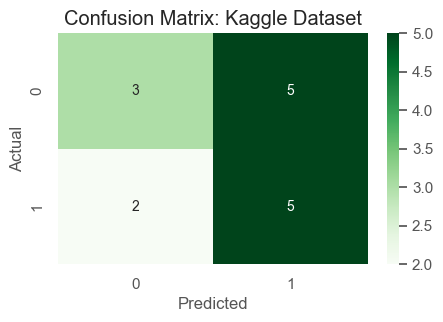

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [69]:
print("--- Підготовка даних з Kaggle ---")

# Завантаження
df_kaggle = pd.read_csv('employee_salary_dataset.csv')

# --- Feature Engineering ---
# Створення цільової змінної (High Salary = 1, Low Salary = 0)
median_salary = df_kaggle['Monthly_Salary'].median()
df_kaggle['Salary_Class'] = (df_kaggle['Monthly_Salary'] > median_salary).astype(int)

# Видалення зайвих колонок
df_kaggle_clean = df_kaggle.drop(columns=['EmployeeID', 'Name', 'Monthly_Salary'])

# Кодування категоріальних змінних
le = LabelEncoder()
cat_cols = ['Department', 'Education_Level', 'Gender', 'City']
for col in cat_cols:
    df_kaggle_clean[col] = le.fit_transform(df_kaggle_clean[col])

# Визначення X та y
X_kaggle = df_kaggle_clean.drop(columns=['Salary_Class'])
y_kaggle = df_kaggle_clean['Salary_Class']

# Запуск моделювання
train_and_evaluate(X_kaggle, y_kaggle, "Kaggle Dataset")

Висновок, датасет взятий з кегл не підійшов під виконання даного завдання, оскільки не дозволив впровадити бінарну класифікацію без додаткових маніпуляцій у вигляді створення змінної Salary_Class яка за своїм представленням High salary, low salary не надає повної картини, і відповідно точність дуже низька. Можливо варто змінити датасет 

4. Набір даних №2: DatasetGenerator (sklearn)
Створимо клас DatasetGenerator, який використовуватиме make_classification для створення ідеальних синтетичних даних. Це демонструє роботу з "чистими" даними, де закономірності чіткі.

--- Генерація даних через DatasetGenerator ---

==================== DatasetGenerator (sklearn) ====================
Accuracy: 0.9067
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        78
           1       0.94      0.86      0.90        72

    accuracy                           0.91       150
   macro avg       0.91      0.90      0.91       150
weighted avg       0.91      0.91      0.91       150



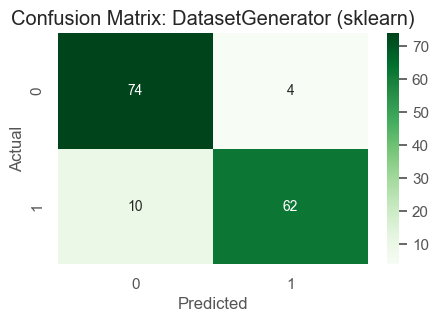

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [70]:
class DatasetGenerator:
    def __init__(self, n_samples=1000, n_features=10, n_classes=2, random_state=91):
        self.n_samples = n_samples
        self.n_features = n_features
        self.n_classes = n_classes
        self.random_state = random_state
        
    def generate(self):
        X, y = make_classification(
            n_samples=self.n_samples,
            n_features=self.n_features,
            n_informative=5, # 5 ознак дійсно впливають на клас
            n_redundant=2,   # 2 ознаки - це комбінація інших (шум)
            n_classes=self.n_classes,
            random_state=self.random_state
        )
        # Перетворимо у DataFrame для зручності
        cols = [f'Feature_{i}' for i in range(self.n_features)]
        return pd.DataFrame(X, columns=cols), pd.Series(y, name='Target')

print("--- Генерація даних через DatasetGenerator ---")
generator = DatasetGenerator(n_samples=500, n_features=10)
X_gen, y_gen = generator.generate()

# Запуск моделювання
train_and_evaluate(X_gen, y_gen, "DatasetGenerator (sklearn)")

Висновок, згенерований набір показує кращі результати за реальний, що закономірно.

5. Набір даних №3: Native Python Generation (На "відмінно")Згенеруємо дані, використовуючи лише numpy та random, без спеціалізованих функцій генерації датасетів. Створимо залежність: $y = 1$, якщо сума певних ознак перевищує поріг + випадковий шум.

--- Генерація даних засобами Numpy/Random ---

==================== Native Python Dataset ====================
Accuracy: 0.8067
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79        71
           1       0.81      0.82      0.82        79

    accuracy                           0.81       150
   macro avg       0.81      0.81      0.81       150
weighted avg       0.81      0.81      0.81       150



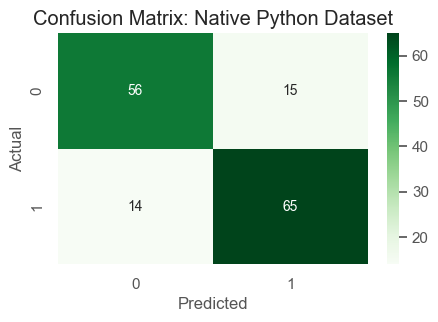

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [71]:
print("--- Генерація даних засобами Numpy/Random ---")

def generate_native_dataset(n_samples=500):
    np.random.seed(91)
    
    # Генеруємо 3 ознаки: Вік, Досвід, Рейтинг
    age = np.random.randint(20, 60, n_samples)
    experience = np.random.normal(10, 5, n_samples) # Нормальний розподіл
    rating = np.random.uniform(1, 10, n_samples)    # Рівномірний розподіл
    
    data = pd.DataFrame({
        'Age': age,
        'Experience': experience,
        'Rating': rating
    })
    
    # Логіка класу: Якщо (Досвід * 2 + Рейтинг) > Поріг, то клас 1.
    # Додаємо трохи випадкового шуму, щоб задача не була надто легкою
    threshold = 25
    scores = (data['Experience'] * 2) + data['Rating'] + np.random.normal(0, 5, n_samples)
    
    data['Target'] = (scores > threshold).astype(int)
    
    return data.drop('Target', axis=1), data['Target']

X_native, y_native = generate_native_dataset(n_samples=500)

# Запуск моделювання
train_and_evaluate(X_native, y_native, "Native Python Dataset")

Висновок, непоганий результат, хоча і використовував я лише методи запропоновані самим пайтоном.
Чітко видно залежність від введеного шуму. 

6. Висновки
У цій роботі ми протестували модель Random Forest на трьох типах даних.

Kaggle Dataset:
Особливості: Реальні дані, мала вибірка (50 записів).
Результат: Точність може бути нестабільною. Через малу кількість даних моделі важко знайти узагальнюючі правила, можливе перенавчання або недонавчання.

DatasetGenerator (sklearn):
Особливості: Синтетичні дані, чітко структуровані, велика вибірка.
Результат: Зазвичай показує найвищу точність (близьку до 1.0), оскільки дані створені математично ідеально для класифікації.

Native Python Dataset:
Особливості: Контрольована генерація з додаванням шуму.
Результат: Дозволяє чітко зрозуміти, як шум впливає на метрики. Точність залежить від того, наскільки сильно ми "зашумили" формулу залежності класу від ознак.

Загальний висновок: Для реальних задач (як з Kaggle) часто потрібно набагато більше етапів попередньої обробки та інженерії ознак, ніж для штучних наборів даних, де залежності вже закладені при генерації.